# Gradient-based functional connectivity

preprocessing
* ~~threshold matrix (row-wise thresholding with 10%, by significance, set to 0)~~
* ~~fisher transform correlations~~
* ~~group-level (IS)FC matrix~~

comparisons
* different preprocessing methods
* encoding model weight matrices
* do with encoding model prediction
* compare with story listening for same subject (FC, and MFC)

exploration
* behavioral scores correlate gradients at each parcel
* variance explained of component is important (eg dimensionality)
* behavioral scores are what we care about, but what about the brain
* lags? by staggering time series

reliability
* split half
* content-specific or brain-state specific?
* three-stages of prompts (gets more personal)

considerations
* ICA cleaning to remove motion components
* look at both scores and weights

References
- Hong et al 2020 toward a gradient based framework (compares PCA, GM, eig)

## Setup

In [1]:
# import sys
# from importlib import reload
# reload(sys.modules["util.plot"])

import h5py
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from util.path import Path
from scipy.spatial.distance import cdist, pdist, squareform

from util import plot, subject
from util.atlas import Atlas
from constants import SUBS_STRANGERS

from sklearn.preprocessing import LabelEncoder
from brainspace.gradient import GradientMaps

import warnings

warnings.filterwarnings("ignore")

In [2]:
%cd ..

/scratch/gpfs/zzada/fconv


In [3]:
modelname = "model-opt-7b_layer-23"
features = ["task", "spectral", "articulation", "prod-LLM", "comp-LLM"]

encmodel = "encoding/trialmot6"
cache = encmodel.split("/")[-1]

modelname, encmodel, cache

('model-opt-7b_layer-23', 'encoding/trialmot6', 'trialmot6')

In [4]:
atlas = Atlas.schaefer2018(networks=7)
networks = LabelEncoder().fit_transform([label.split("_")[2] for label in atlas.labels])
len(np.unique(networks))

7

In [5]:
resultCache = f"cache/{modelname}/{cache}/figure-gradients/"
!mkdir -p $resultCache
!ls -l $resultCache

total 333888
-rw-r--r--. 1 zzada uhasson 109892048 Mar 25 10:13 narrative-within-subject-distsW.hdf5
-rw-r--r--. 1 zzada uhasson 232002048 Mar 22 13:35 within-subject-noMotCorr.hdf5


# narrative

In [6]:
# not all subjects have this..
SUBS_NAR = list(SUBS_STRANGERS)
SUBS_NAR.remove(11)
SUBS_NAR.remove(111)
SUBS_NAR.remove(12)

## within-subject FC

In [7]:
# from black_encoding import get_bold

In [8]:
cache_path = Path(
    root="data/derivatives/cleaned",
    datatype="func",
    sub="000",
    task="Black",
    space="fsaverage6",
    suffix="bold",
    ext="hdf5",
)

distsW = np.zeros((len(SUBS_NAR), 1000**2 // 2 - 500), dtype=np.float32)
for i, sub in enumerate(tqdm(SUBS_NAR)):
    # get BOLD data
    cache_path.update(sub=f"{sub:03d}")
    if cache_path.isfile():
        with h5py.File(cache_path, "r") as f:
            boldA = f["bold"][...]
    else:
        print("WARNING", sub)
        # boldA = get_bold(sub)

    boldParcA = atlas.vox_to_parc(boldA)
    distsW[i] = pdist(boldParcA.T, metric="correlation")

100%|██████████| 55/55 [00:32<00:00,  1.70it/s]


### analysis

(1000, 1000)


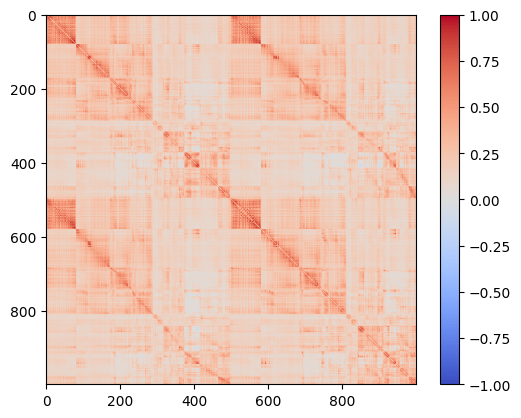

In [15]:
distsWithin = squareform(np.arctanh(1 - distsW).mean(0))
print(distsWithin.shape)

fig, ax = plt.subplots()
im = ax.imshow(distsWithin, cmap="coolwarm", vmin=-1, vmax=1)
fig.colorbar(im, ax=ax)
fig.show()

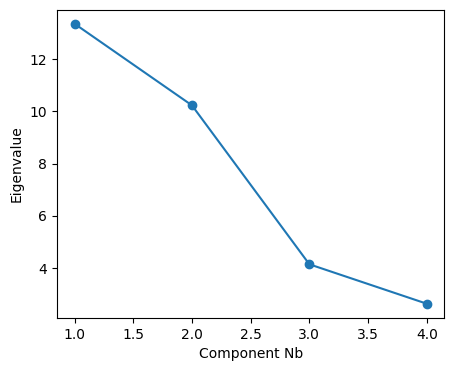

In [16]:
gm = GradientMaps(n_components=4, random_state=0, approach="dm")
gm.fit(distsWithin)

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.plot(range(1, gm.lambdas_.size + 1), gm.lambdas_, marker="o")
ax.set_xlabel("Component Nb")
ax.set_ylabel("Eigenvalue")
fig.show()

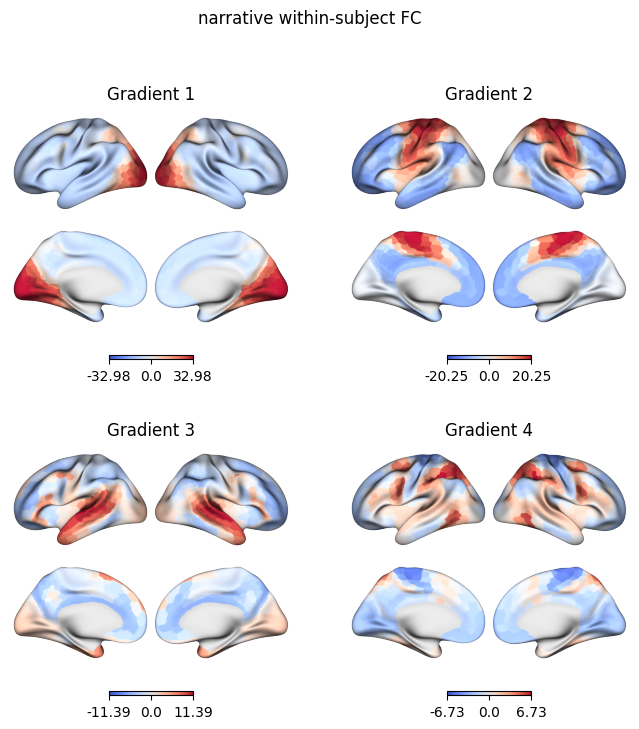

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axes.ravel()):
    gradient = gm.gradients_[:, i]
    compVox = atlas.parc_to_vox(gradient)
    plot.surface_plot(compVox, title=f"Gradient {i+1}", fig=fig, ax=ax)

fig.suptitle("narrative within-subject FC")
fig.show()

### relates with behavior

compute gradient per subject FC, correlate each parcel with behavioral ratings

In [9]:
import pandas as pd
from himalaya.scoring import correlation_score

In [10]:
df_scores = pd.read_csv("mats/black_comprehension.csv", index_col="ID")
compScores = df_scores.loc[SUBS_NAR].comprehension_score.to_numpy()

In [14]:
gradients = []
for i, sub in enumerate(tqdm(SUBS_NAR)):
    D = squareform(np.arctanh(1 - distsW[i]))
    gm = GradientMaps(
        n_components=4, random_state=0, approach="dm"
    )  # NOTE random state
    gm.fit(D)
    gradients.append(gm.gradients_)
gradients = np.stack(gradients)
gradients.shape

100%|██████████| 55/55 [00:36<00:00,  1.51it/s]


(55, 1000, 4)

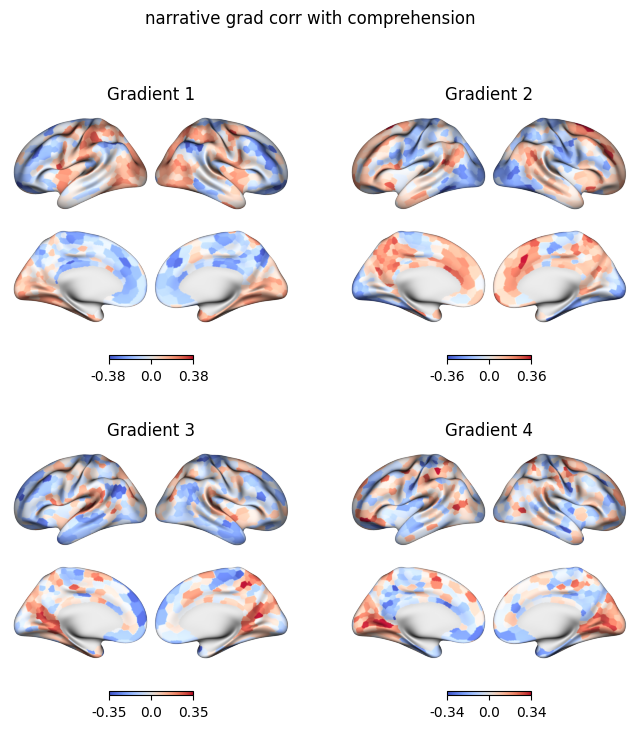

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axes.ravel()):
    scores = correlation_score(compScores[:, None], gradients[:, :, i])

    compVox = atlas.parc_to_vox(scores)
    plot.surface_plot(compVox, title=f"Gradient {i+1}", fig=fig, ax=ax)

fig.suptitle("narrative grad corr with comprehension")
fig.show()

## model-predicted bold

In [13]:
# load black preds
respath = Path(
    root="encoding/black",
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

distsW = np.zeros((len(SUBS_NAR), 1000**2 // 2 - 500), dtype=np.float32)
for i, sub in enumerate(tqdm(SUBS_NAR)):
    respath.update(sub=f"{sub:03d}")
    with h5py.File(respath, "r") as f:
        boldPred = f["cv_preds"][:, -1].reshape(534, -1)
        boldParcA = atlas.vox_to_parc(boldPred)
        distsW[i] = pdist(boldParcA.T, metric="correlation")

  0%|          | 0/55 [00:00<?, ?it/s]

100%|██████████| 55/55 [00:34<00:00,  1.57it/s]


(1000, 1000)


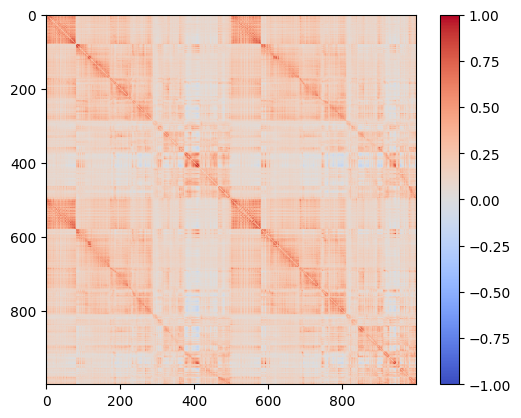

In [11]:
distsWithin = squareform(np.arctanh(1 - distsW).mean(0))
# distswithin = np.nan_to_num(distsWithin, copy=False, posinf=0.999, neginf=-0.999)
print(distsWithin.shape)

fig, ax = plt.subplots()
im = ax.imshow(distsWithin, cmap="coolwarm", vmin=-1, vmax=1)
fig.colorbar(im, ax=ax)
fig.show()

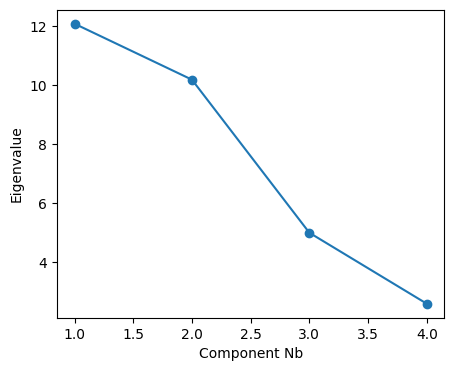

In [12]:
gm = GradientMaps(n_components=4, random_state=0, approach="dm")
gm.fit(distsWithin)

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.plot(range(1, gm.lambdas_.size + 1), gm.lambdas_, marker="o")
ax.set_xlabel("Component Nb")
ax.set_ylabel("Eigenvalue")
fig.show()

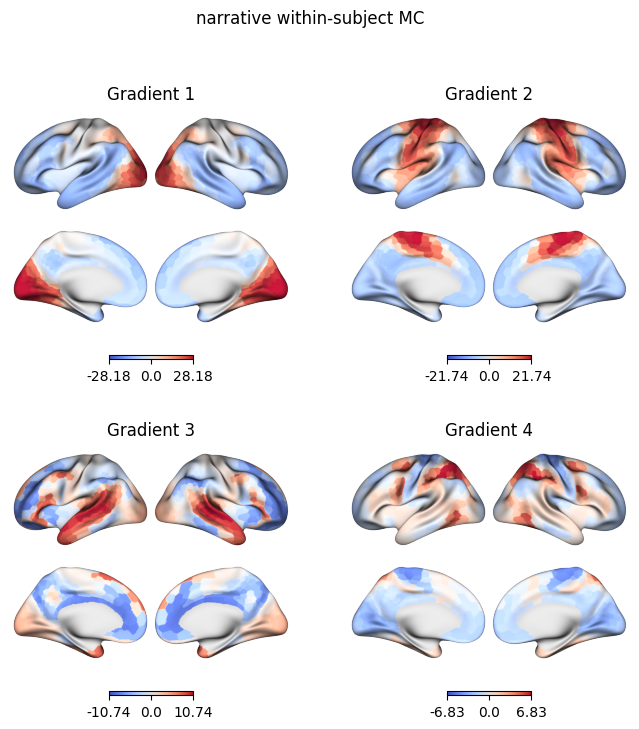

In [13]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axes.ravel()):
    gradient = gm.gradients_[:, i]
    compVox = atlas.parc_to_vox(gradient)
    plot.surface_plot(compVox, title=f"Gradient {i+1}", fig=fig, ax=ax)

fig.suptitle("narrative within-subject MC")
fig.show()

## intersubject FC

In [44]:
cache_path = Path(
    root="data/derivatives/cleaned",
    datatype="func",
    sub="000",
    task="Black",
    space="fsaverage6",
    suffix="bold",
    ext="hdf5",
)

bolds = []
for i, sub in enumerate(tqdm(SUBS_NAR)):
    # get BOLD data
    cache_path.update(sub=f"{sub:03d}")
    if cache_path.isfile():
        with h5py.File(cache_path, "r") as f:
            boldA = f["bold"][...]
    else:
        print("WARNING", sub)
        # boldA = get_bold(sub)

    bolds.append(atlas.vox_to_parc(boldA))

100%|██████████| 55/55 [00:33<00:00,  1.66it/s]


In [46]:
boldParcA = np.stack(bolds).mean(0)
print(boldParcA.shape)

distsW = pdist(boldParcA.T, metric="correlation")
distsW.shape

(534, 1000)


(499500,)

(1000, 1000)


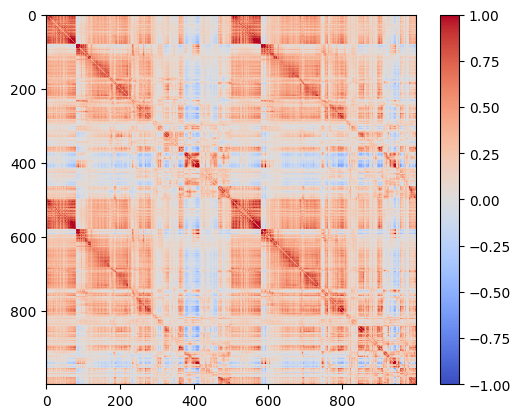

In [48]:
distsWithin = squareform(np.arctanh(1 - distsW))
print(distsWithin.shape)

fig, ax = plt.subplots()
im = ax.imshow(distsWithin, cmap="coolwarm", vmin=-1, vmax=1)
fig.colorbar(im, ax=ax)
fig.show()

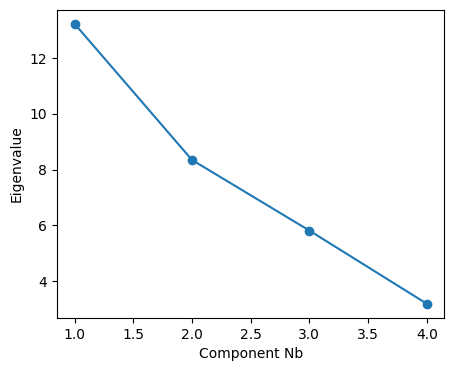

In [49]:
gm = GradientMaps(n_components=4, random_state=0, approach="dm")
gm.fit(distsWithin)

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.plot(range(1, gm.lambdas_.size + 1), gm.lambdas_, marker="o")
ax.set_xlabel("Component Nb")
ax.set_ylabel("Eigenvalue")
fig.show()

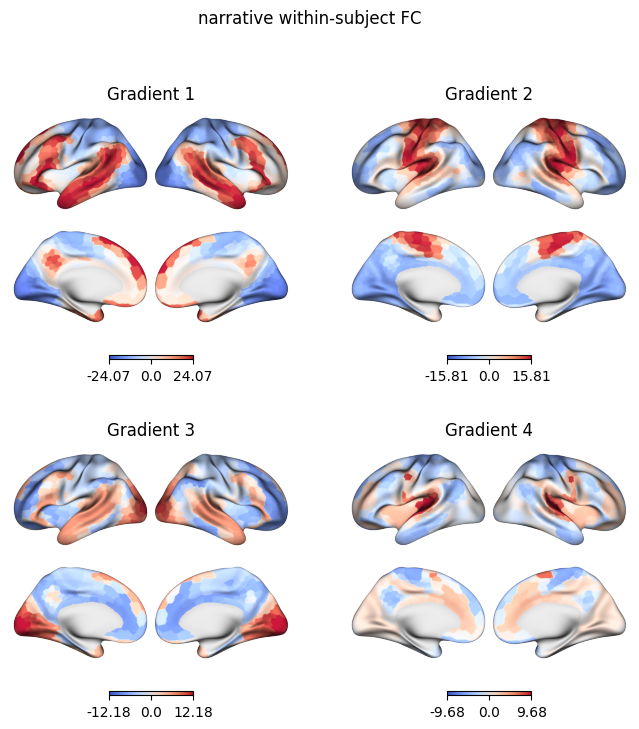

In [50]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axes.ravel()):
    gradient = gm.gradients_[:, i]
    compVox = atlas.parc_to_vox(gradient)
    plot.surface_plot(compVox, title=f"Gradient {i+1}", fig=fig, ax=ax)

fig.suptitle("narrative ISFC")
fig.show()

# conversation

## within subject FC

In [16]:
distsW = np.zeros((len(SUBS_STRANGERS), 1000**2 // 2 - 500), dtype=np.float32)

for i, subA in enumerate(tqdm(SUBS_STRANGERS)):
    boldA = subject.get_bold(subA, use_cache=True, cache_desc=cache)
    # boldA = subject.get_bold(
    #     subA, run_confounds=[], trial_confounds=[], use_cache=False
    # )
    boldParcA = atlas.vox_to_parc(boldA)
    distsW[i] = pdist(boldParcA.T, metric="correlation")

100%|██████████| 58/58 [01:10<00:00,  1.21s/it]


In [130]:
# # save
# with h5py.File(f"{resultCache}/within-subject-noMotCorr.hdf5", "w") as f:
#     f.create_dataset(name="distsW", data=distsW)

(1000, 1000)


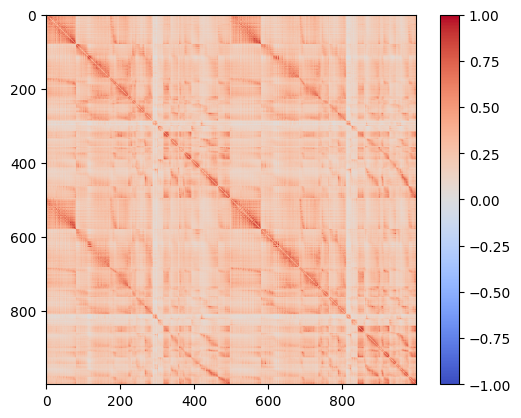

In [17]:
distsWithin = squareform(np.arctanh(1 - distsW).mean(0))
print(distsWithin.shape)

fig, ax = plt.subplots()
im = ax.imshow(distsWithin, cmap="coolwarm", vmin=-1, vmax=1)
fig.colorbar(im, ax=ax)
fig.show()

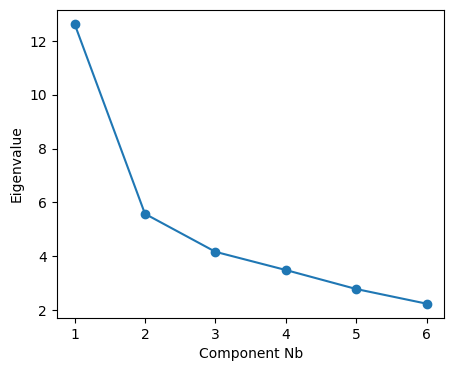

In [18]:
gm = GradientMaps(n_components=6, random_state=0, approach="dm")
gm.fit(distsWithin)

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.plot(range(1, gm.lambdas_.size + 1), gm.lambdas_, marker="o")
ax.set_xlabel("Component Nb")
ax.set_ylabel("Eigenvalue")
fig.show()

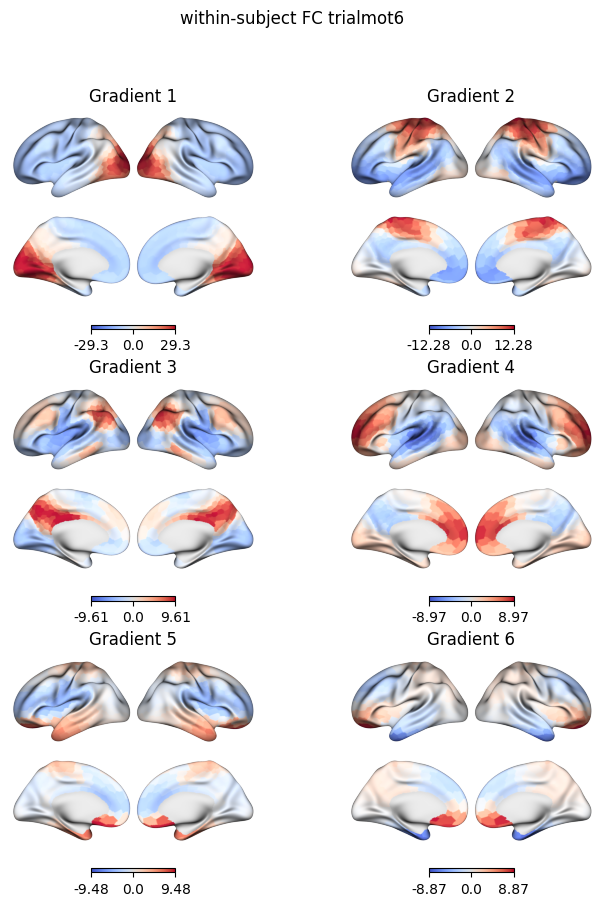

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))

for i, ax in enumerate(axes.ravel()):
    gradient = gm.gradients_[:, i]
    compVox = atlas.parc_to_vox(gradient)
    plot.surface_plot(compVox, title=f"Gradient {i+1}", fig=fig, ax=ax)

fig.suptitle("within-subject FC trialmot6")
fig.show()

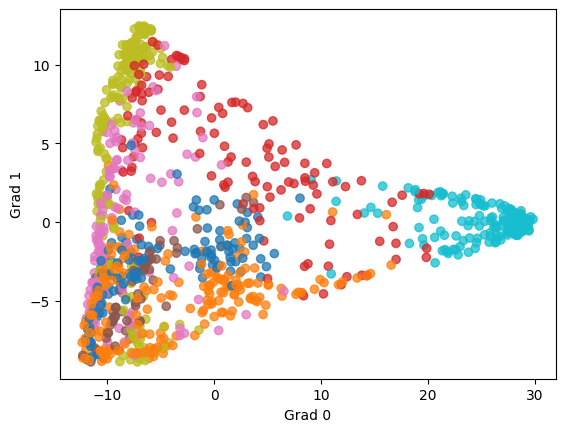

In [201]:
fig, ax = plt.subplots()
grad1 = gm.gradients_[:, 0]
grad2 = gm.gradients_[:, 1]
ax.scatter(grad1, grad2, c=networks, cmap="tab10", alpha=0.75)
ax.set(xlabel="Grad 0", ylabel="Grad 1")
fig.show()

## intersubject FC

In [21]:
distsAB = np.zeros((len(SUBS_STRANGERS[:29]), 1000, 1000), dtype=np.float32)

for i, subA in enumerate(tqdm(SUBS_STRANGERS[:29])):
    subB = subject.get_partner(subA)

    boldA = subject.get_bold(subA, use_cache=True, cache_desc=cache)
    boldB = subject.get_bold(subB, use_cache=True, cache_desc=cache)

    boldParcA = atlas.vox_to_parc(boldA)
    boldParcB = atlas.vox_to_parc(boldB)

    distsAB[i] = cdist(boldParcA.T, boldParcB.T, metric="correlation")

100%|██████████| 29/29 [01:01<00:00,  2.11s/it]


In [240]:
lags = np.arange(-10, 11)

distsABL = np.zeros((len(SUBS_STRANGERS[:29]), len(lags), 1000, 1000), dtype=np.float32)

for i, subA in enumerate(tqdm(SUBS_STRANGERS[:29])):
    subB = subject.get_partner(subA)

    boldA = subject.get_bold(subA, use_cache=True, cache_desc=cache)
    boldB = subject.get_bold(subB, use_cache=True, cache_desc=cache)

    boldParcA = atlas.vox_to_parc(boldA)
    boldParcB = atlas.vox_to_parc(boldB)

    for j, lag in enumerate(lags):
        if lag < 0:
            trialA = boldParcA[:lag]
            trialB = boldParcB[-lag:]
        elif lag > 0:
            trialA = boldParcA[lag:]
            trialB = boldParcB[:-lag]
        else:
            trialA = boldParcA
            trialB = boldParcB

        distsABL[i, j] = cdist(trialA.T, trialB.T, metric="correlation")

100%|██████████| 29/29 [07:29<00:00, 15.50s/it]


In [273]:
# distsAB = distsABL.min(1)
distsAB = distsABL[:, 11]
distsAB.shape

(29, 1000, 1000)

(1000, 1000)


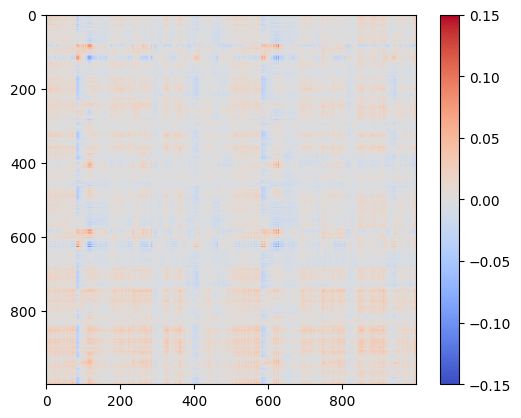

In [25]:
distsBetween = np.arctanh(1 - distsAB).mean(0)
print(distsBetween.shape)

fig, ax = plt.subplots()
im = ax.imshow(distsBetween, cmap="coolwarm", vmin=-0.15, vmax=0.15)
fig.colorbar(im, ax=ax)
fig.show()

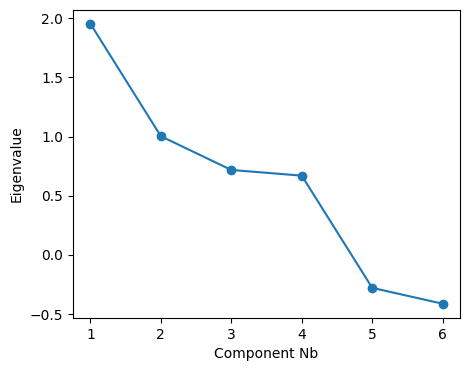

In [26]:
gm = GradientMaps(n_components=6, random_state=0, approach="dm")
gm.fit(distsBetween)

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.plot(range(1, gm.lambdas_.size + 1), gm.lambdas_, marker="o")
ax.set_xlabel("Component Nb")
ax.set_ylabel("Eigenvalue")
fig.show()

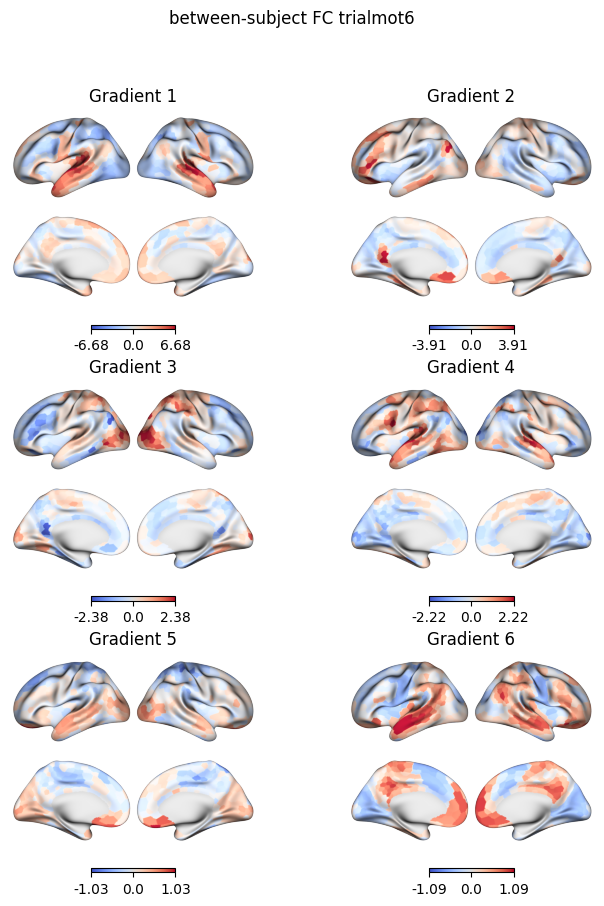

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))

for i, ax in enumerate(axes.ravel()):
    gradient = gm.gradients_[:, i]
    compVox = atlas.parc_to_vox(gradient)
    plot.surface_plot(compVox, title=f"Gradient {i+1}", fig=fig, ax=ax)

fig.suptitle("between-subject FC trialmot6")
fig.show()

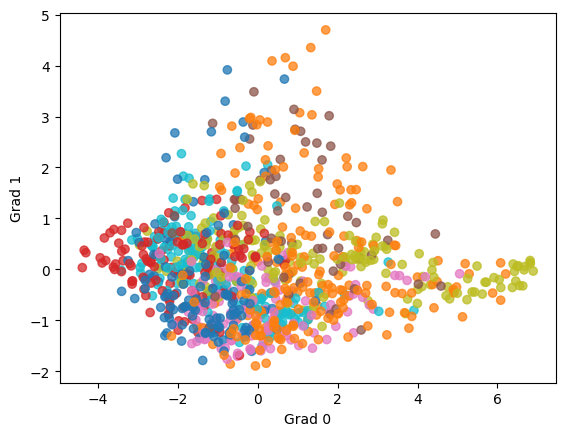

In [213]:
fig, ax = plt.subplots()
grad1 = gm.gradients_[:, 0]
grad2 = gm.gradients_[:, 1]
ax.scatter(grad1, grad2, c=networks, cmap="tab10", alpha=0.75)
ax.set(xlabel="Grad 0", ylabel="Grad 1")
fig.show()

## model-predicted BOLD

### within subject

In [29]:
distsW = np.zeros((len(SUBS_STRANGERS), 1000**2 // 2 - 500), dtype=np.float32)

for i, subA in enumerate(tqdm(SUBS_STRANGERS)):
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        prodPredA = f["cv_preds"][:, -2, ...].reshape(1200, -1)
        compPredA = f["cv_preds"][:, -1, ...].reshape(1200, -1)
    predParcA = prodPredA + compPredA

    boldParcA = atlas.vox_to_parc(predParcA)
    distsW[i] = pdist(boldParcA.T, metric="correlation")

100%|██████████| 58/58 [02:44<00:00,  2.84s/it]


(1000, 1000)


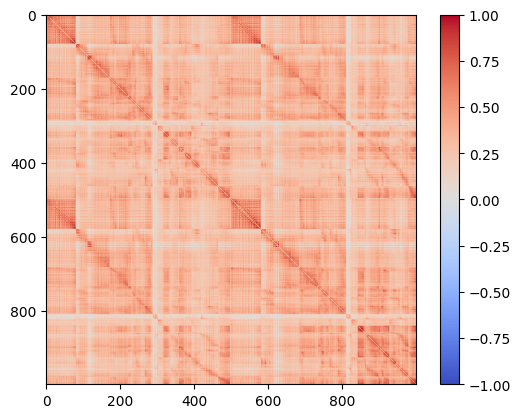

In [35]:
distsWithin = squareform(np.arctanh(1 - distsW).mean(0))
print(distsWithin.shape)

fig, ax = plt.subplots()
im = ax.imshow(distsWithin, cmap="coolwarm", vmin=-1, vmax=1)
fig.colorbar(im, ax=ax)
fig.show()

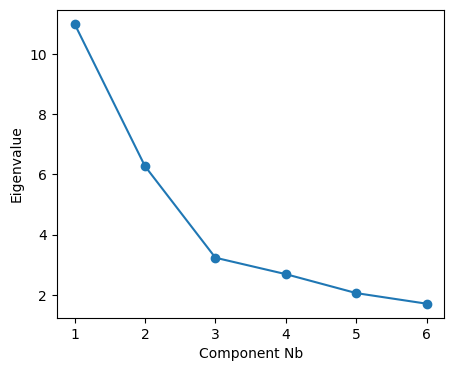

In [36]:
gm = GradientMaps(n_components=6, random_state=0, approach="dm")
gm.fit(distsWithin)

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.plot(range(1, gm.lambdas_.size + 1), gm.lambdas_, marker="o")
ax.set_xlabel("Component Nb")
ax.set_ylabel("Eigenvalue")
fig.show()

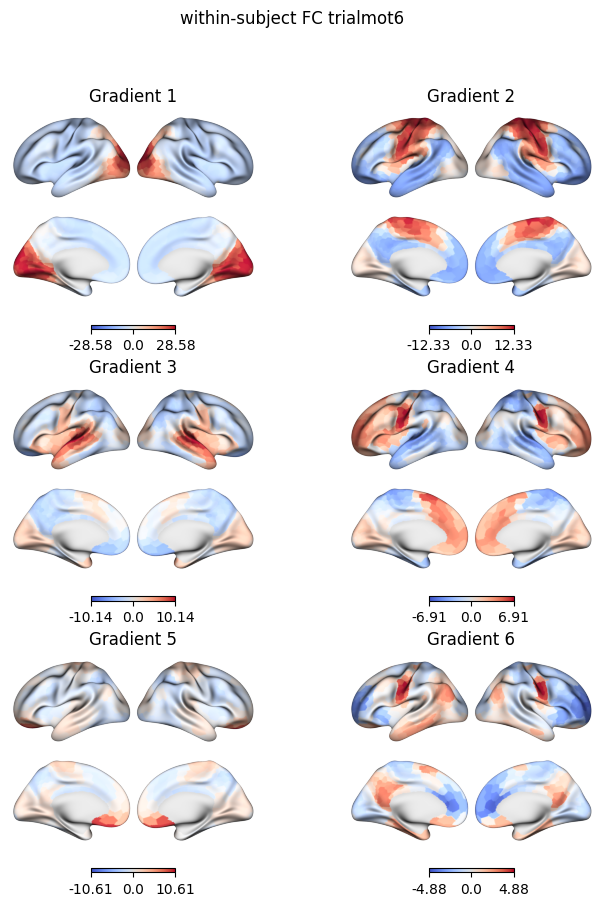

In [37]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))

for i, ax in enumerate(axes.ravel()):
    gradient = gm.gradients_[:, i]
    compVox = atlas.parc_to_vox(gradient)
    plot.surface_plot(compVox, title=f"Gradient {i+1}", fig=fig, ax=ax)

fig.suptitle("within-subject MC trialmot6")
fig.show()

### between subjects

In [38]:
distsAB = np.zeros((len(SUBS_STRANGERS), 1000, 1000), dtype=np.float32)

for i, subA in enumerate(tqdm(SUBS_STRANGERS)):
    encpath = Path(root=encmodel, sub=f"{subA:03d}", datatype=modelname, ext=".hdf5")
    with h5py.File(encpath, "r") as f:
        predA = f["cv_preds"][:, -2:, ...].sum(1).reshape(1200, -1)  # add prod and comp
    predParcA = atlas.vox_to_parc(predA)

    subB = subject.get_partner(subA)  # within subject
    boldB = subject.get_bold(subB, use_cache=True, cache_desc=cache)
    boldParcB = atlas.vox_to_parc(boldB)

    distsAB[i] = cdist(predParcA.T, boldParcB.T, metric="correlation")

  0%|          | 0/58 [00:00<?, ?it/s]

100%|██████████| 58/58 [03:00<00:00,  3.11s/it]


(1000, 1000)


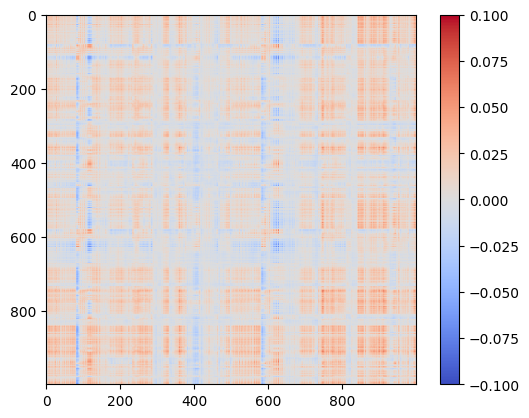

In [41]:
distsBetween = np.arctanh(1 - distsAB).mean(0)
print(distsBetween.shape)

fig, ax = plt.subplots()
im = ax.imshow(distsBetween, cmap="coolwarm", vmin=-0.1, vmax=0.1)
fig.colorbar(im, ax=ax)
fig.show()

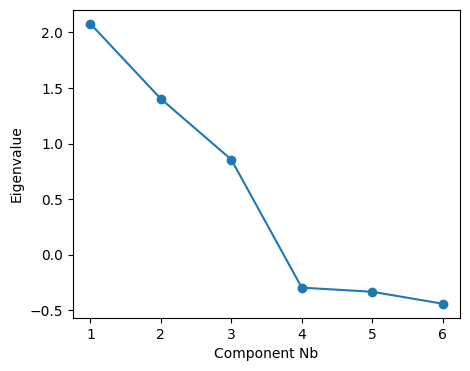

In [42]:
gm = GradientMaps(n_components=6, random_state=0, approach="dm")
gm.fit(distsBetween)

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.plot(range(1, gm.lambdas_.size + 1), gm.lambdas_, marker="o")
ax.set_xlabel("Component Nb")
ax.set_ylabel("Eigenvalue")
fig.show()

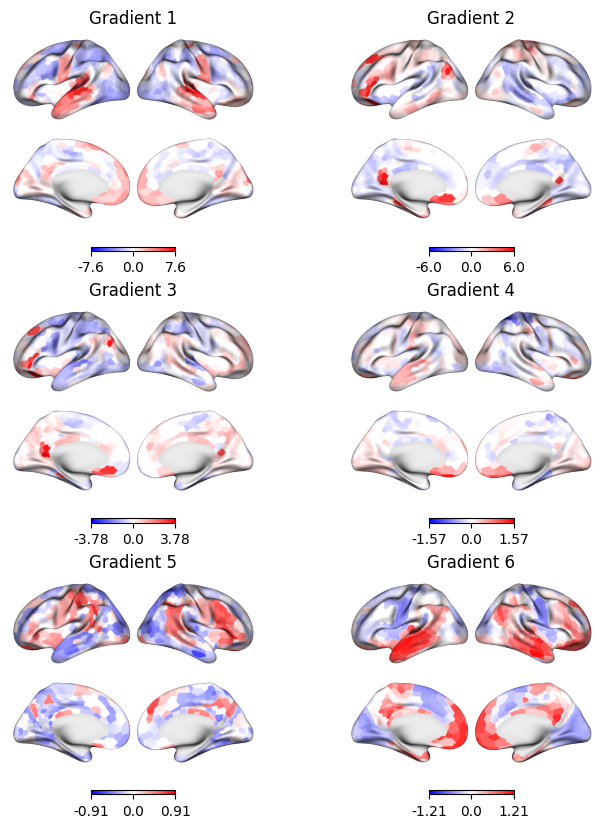

In [43]:
fig, axes = plt.subplots(3, 2, figsize=(8, 10))

for i, ax in enumerate(axes.ravel()):
    gradient = gm.gradients_[:, i]
    compVox = atlas.parc_to_vox(gradient)
    plot.surface_plot(compVox, title=f"Gradient {i+1}", fig=fig, ax=ax, cmap="bwr")

fig.show()

## model weights

consider using gpt-2 becauase weights are much smaller but perform similarly

In [159]:
weightSimWithin = np.zeros((29, 1000, 1000), dtype=np.float32)
weightSimBetween = np.zeros((29, 1000, 1000), dtype=np.float32)

respath = Path(
    root=encmodel,
    sub="000",
    datatype=modelname,
    ext=".hdf5",
)

for i, sub in enumerate(tqdm(SUBS_STRANGERS[:29])):  # NOTE iterating only half
    respath.update(sub=f"{sub:03d}")
    with h5py.File(respath, "r") as f:
        weights_prodA = f["cv_weights_prod"][...].mean(0)
        weights_compA = f["cv_weights_comp"][...].mean(0)
        corr_prodA = f["cv_scores_prod"][:, -2, :].mean(0)
        corr_compA = f["cv_scores_comp"][:, -1, :].mean(0)

    # subB = subject.get_partner(sub)
    # respath.update(sub=f"{subB:03d}")
    # with h5py.File(respath, "r") as f:
    #     weights_prodB = f["cv_weights_prod"][...].mean(0)
    #     weights_compB = f["cv_weights_comp"][...].mean(0)
    #     corr_prodB = f["cv_scores_prod"][...].mean(0)
    #     corr_compB = f["cv_scores_comp"][...].mean(0)

    # consider unit-norming and rescaling by score before computing correlation
    norms = np.linalg.norm(weights_prodA, ord=2, axis=0)
    weights_prodA /= norms
    weights_prod = np.nan_to_num(weights_prodA, copy=False, nan=0)
    r2_prod = np.square(corr_prodA)
    r2_prod = np.clip(r2_prod, a_min=0, a_max=None, out=r2_prod)
    weights_prodA *= r2_prod

    norms = np.linalg.norm(weights_compA, ord=2, axis=0)
    weights_compA /= norms
    weights_compA = np.nan_to_num(weights_compA, copy=False, nan=0)
    r2_comp = np.square(corr_compA)
    r2_comp = np.clip(r2_comp, a_min=0, a_max=None, out=r2_comp)
    weights_compA *= r2_comp

    # reduce to the atlas
    weights_prodA = atlas.vox_to_parc(weights_prodA)
    # weights_prodB = atlas.vox_to_parc(weights_prodB)
    weights_compA = atlas.vox_to_parc(weights_compA)
    # weights_compB = atlas.vox_to_parc(weights_compB)

    weightSimWithin[i] = cdist(weights_prodA.T, weights_compA.T, metric="euclidean")
    # weightSimBetween[i] = 1 - cdist(weights_prodA.T, weights_compB.T, metric='correlation')

 14%|█▍        | 4/29 [04:56<30:55, 74.23s/it]


KeyboardInterrupt: 

In [164]:
withinWeightSim = weightSimWithin[:3].mean(0)
withinWeightSim.shape

(1000, 1000)

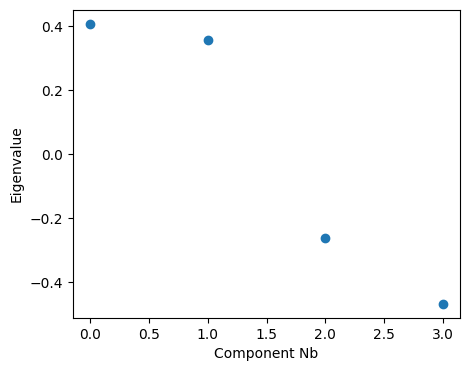

In [165]:
gm = GradientMaps(n_components=4, random_state=0, approach="dm")
gm.fit(withinWeightSim)

fig, ax = plt.subplots(1, figsize=(5, 4))
ax.scatter(range(gm.lambdas_.size), gm.lambdas_)
ax.set_xlabel("Component Nb")
ax.set_ylabel("Eigenvalue")
fig.show()

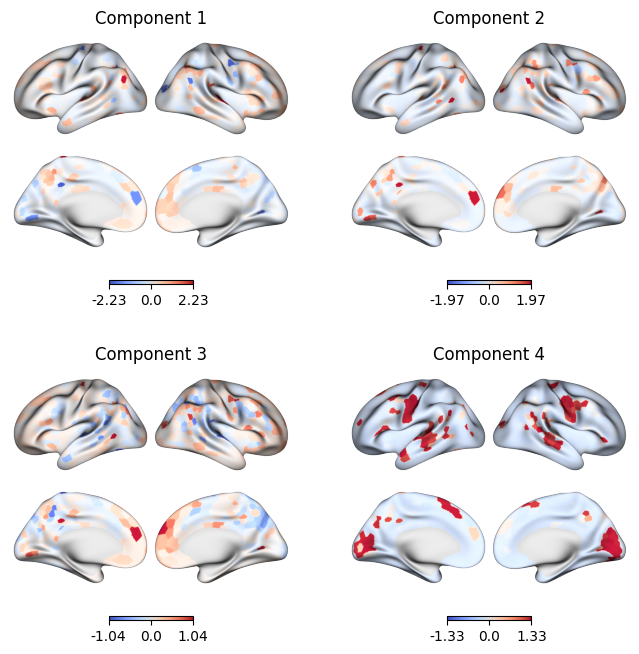

In [166]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8))

for i, ax in enumerate(axes.ravel()):
    gradient = gm.gradients_[:, i]
    compVox = atlas.parc_to_vox(gradient)
    plot.surface_plot(compVox, title=f"Component {i+1}", fig=fig, ax=ax)

fig.show()